In [3]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from scipy import optimize
from scipy.optimize import LinearConstraint
from scipy.optimize import NonlinearConstraint
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.spatial.distance import cdist
from importlib import reload
import class_flp
import utils
import time
import random
import pickle

seed: 830
x0	shape:(606,)


/Users/dhananjaytiwari/Documents/NASA_ULI/CDC2025/CBF_MEP_based_constrained_Resource_Allocation/class_flp.py:720: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(Y_init[:, 0], Y_init[:, 1], marker = "x", c=resource_colors, s=100, edgecolor='k', alpha=0.4, label='Initial Resource Locations')


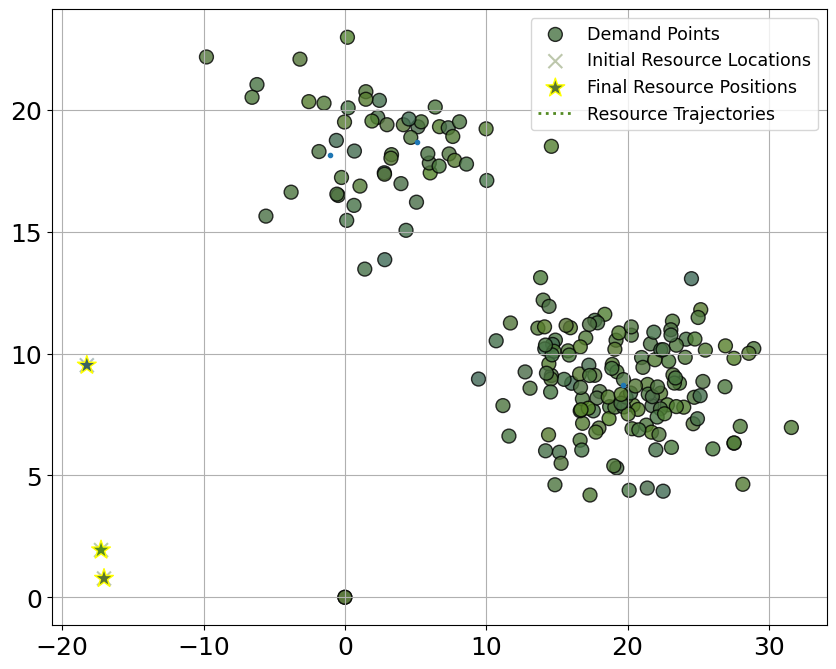

rho shape: (200, 1)
cluster split: [0.11456013 0.16729958 0.7181403 ]
upper allocation cost limit: [0.28503586 0.43805175 0.33691239]
lower allocation cost limit: [0.168792   0.17003674 0.14710257]
res means: [[-1.04467514 18.15243428]
 [ 5.1013918  18.67263057]
 [19.67935375  8.71867947]]
centroid:[14.79755331 11.31160763]


In [4]:
reload(utils)
reload(class_flp)

# load/generate a testcase
N = 200
M = 3
d = 2
scale = 20
seed = random.randint(0,1000)
# 123, 233, 94, 830 for N = 1000, M = 10, 
# 864 for N = 400, M = 3
# 349, 700, 477, 278 for N = 400, M = 4
seed = 830
print(f'seed: {seed}')
# N, M, d, resLoc, Y0, res_means, split_pct, rho = testcases.testcase_catalog('small_tc_300_3')
resLoc, Y0, res_means, split_pct, rho = utils.generate_testcase(
    N, M, d, unif_split=False, cluster_cov=20, seed=seed, sq_size=scale, normalizer=False)
# allocation cost
alloc_cost = np.random.uniform(1,1,(N,M))
mean_alloc_cost = np.mean(alloc_cost)
np.random.seed(seed)
C = np.random.uniform(0.3,1,len(split_pct))
# C = np.ones(shape=split_pct.shape)
C = (C/np.sum(C) + 0.02) * mean_alloc_cost
B = np.random.uniform(C.min()*0.3, C.min()*0.6, len(split_pct))

# initialize FLP class
flp = class_flp.FLP(N, M, d, resLoc, rho, C, B, alloc_cost, P_eps=1e-20, beta_tol=1e-10)

# initialize state
Y0 = np.column_stack((np.random.uniform(-20.0, -15.0, flp.M), 
                          np.random.uniform(0.0, 10.0, flp.M)))
# Y0 = np.random.uniform(0*scale,1*scale,(flp.M, flp.d))
np.random.seed(seed)
P0 = np.random.uniform(0.0,1,(flp.N, flp.M)) + flp.P_eps
P0 = P0/P0.sum(axis=1,keepdims=True)
x0 = utils.YP2x(Y0, P0); print(f'x0\tshape:{x0.shape}')

class_flp.plot_flp(flp, res_means, np.expand_dims(Y0,axis=0), np.expand_dims(P0,axis=0),figSize=(10,8))
print(f'rho shape: {rho.shape}')
print(f'cluster split: {split_pct}')
print(f'upper allocation cost limit: {C}')
print(f'lower allocation cost limit: {B}')
print(f'res means: {res_means}')
centroid = np.sum(rho*resLoc, axis=0)
print(f'centroid:{centroid}')


In [8]:
# parameters for deterministic annealing based optimization
b1_min = 0.005
b1_max = 200
b1_grow = 5
theta = 5
n_iters = 1000
D_tol = 1e-4

# Setting the coefficients for CBF CLF based optimization
alpha_h = 20
alpha_l = 20
p1 = 1
p2 = 10
gamma = 20
u_b = 0.0

# SGF
alpha = 1
kappa = 1

T_f = 10
dt_init = 0.05
dt_max = 0.1
dt_min = 1e-4
Ftol = 0.01 # same for SLSQP and SGF
xtol = 1e-3

# annealing parameters
beta0 = 1e-3
betaf = 1e2
beta_grow = 2

# plot directory
# dir = 'Simulations_and_Results/final_results/Compare_CBF_SGF_AmberPenalty/'
# dir = 'Simulations_and_Results/final_results/LargeProblem/'

### DA with MEP for constraints multipliers

In [5]:
# D = flp.get_D(Y0)
# P = P0
# beta1 = 1e-3
# beta = 1e-4
# Li, G = flp.get_Li(P, beta1)
# dGdP = np.concatenate(list(map(np.diag, flp.rho * flp.alloc_C))).T
# Pi, Yi = flp.get_PYL_gibbs(D, P, Li, dGdP, beta, beta1)
# print(Pi, Yi, Li)

In [6]:
# beta0 = 10
# Pi, Yi, Li = flp.optimize_DA_C1(P0, Y0, beta=beta0, b1_min=beta0, b1_max=beta0, b1_grow=1.5, n_iters=100, D_tol=1e-4, allowPrint1=False, allowPrint2=False)

### Regular DA

In [10]:
t0_da = time.time()
F_arr_da, b_arr_da, P_arr_da, Y_arr_da, t_compute_arr_da, cap_array_da = flp.anneal_DA(Y0, beta0, betaf, beta_grow, n_iters=1000, D_tol=1e-5)
t1_da = time.time()

reload(class_flp)
final_cap = cap_array_da[-1]
constr_viol_c = np.min(flp.C - final_cap)
constr_viol_b = np.min(final_cap - flp.B)
print(f'resource locations:\n{Y_arr_da[-1]}')
print(f'final capacity: {final_cap}')
print(f'upper capacity: {flp.C}')
print(f'lower capacity: {flp.B}')
print(f'Relative capacity constraint violation: {constr_viol_c:.6f}\t{constr_viol_b:.6f}')
# class_flp.plot_flp_with_capacity_1(
#     flp, res_means, Y_arr_da, P_arr_da, x=np.arange(flp.M), 
#     data=cap_array_da[-1], min_vals=flp.B, max_vals=flp.C, 
#     x_expand_factor=0.4, y_expand_factor=0.0, 
#     filedir = dir + 'DA_N2000M15_seed830.pdf' , isSavePDF=False,
#     figSize=(12,10), fontSize=30, inset_loc=[0.71, 0.2, 0.17, 0.4], plotResTraj=True)


tolerance achieved: 	 norm_diff_D=7.106e-06
b:1.000e-03	F:102.6373
tolerance achieved: 	 norm_diff_D=4.501e-06
b:2.000e-03	F:102.6371
tolerance achieved: 	 norm_diff_D=9.654e-06
b:4.000e-03	F:102.6363
tolerance achieved: 	 norm_diff_D=7.637e-06
b:8.000e-03	F:89.9291
tolerance achieved: 	 norm_diff_D=7.184e-06
b:1.600e-02	F:62.0832
tolerance achieved: 	 norm_diff_D=9.517e-06
b:3.200e-02	F:44.1839
tolerance achieved: 	 norm_diff_D=7.867e-06
b:6.400e-02	F:32.0834
tolerance achieved: 	 norm_diff_D=6.528e-06
b:1.280e-01	F:24.6870
tolerance achieved: 	 norm_diff_D=6.682e-06
b:2.560e-01	F:20.6726
tolerance achieved: 	 norm_diff_D=7.908e-06
b:5.120e-01	F:18.6034
tolerance achieved: 	 norm_diff_D=9.422e-06
b:1.024e+00	F:17.5543
tolerance achieved: 	 norm_diff_D=9.677e-06
b:2.048e+00	F:17.0230
tolerance achieved: 	 norm_diff_D=6.288e-06
b:4.096e+00	F:16.7560
tolerance achieved: 	 norm_diff_D=2.837e-06
b:8.192e+00	F:16.6240
tolerance achieved: 	 norm_diff_D=5.873e-08
b:1.638e+01	F:16.5574
toleran

In [11]:
# savedata_da = {'F_arr':F_arr_da, 
#             'b_arr':b_arr_da, 
#             'P_arr':P_arr_da, 
#             'Y_arr':Y_arr_da, 
#             't_compute_arr':t_compute_arr_da, 
#             'cap_array':cap_array_da,
#             'time_sec':t1_da - t0_da,
#             'C':flp.C,
#             'B':flp.B,
#             'alloc_C':flp.alloc_C,
#             'split_pct':split_pct}

# da_data_file = dir + 'DA_N2000M15_seed830.pkl'

# with open(da_data_file, 'wb') as file:
#     pickle.dump(savedata_da, file)

### DA with penalties (Amber's approach)

In [12]:
t0_dac = time.time()
F_arr_dac, b_arr_dac, P_arr_dac, Y_arr_dac, t_compute_arr_dac, cap_array_dac = flp.anneal_DA_C(Y0, beta0, betaf, beta_grow, b1_min, b1_max, b1_grow, theta, n_iters, D_tol)
t1_dac = time.time()


cons_violation: [ 0.048 -0.104 -0.004]
b:2.000e-03	b1_min,b1_max:(1e-05, 0.001)	F:102.6358
cons_violation: [ 0.047 -0.104 -0.004]
b:4.000e-03	b1_min,b1_max:(2e-05, 0.002)	F:102.6358
cons_violation: [ 0.046 -0.103 -0.004]
b:8.000e-03	b1_min,b1_max:(4e-05, 0.004)	F:102.6358
cons_violation: [ 0.065 -0.078 -0.047]
b:1.600e-02	b1_min,b1_max:(8e-05, 0.008)	F:89.9254
cons_violation: [ 0.064 -0.07  -0.054]
b:3.200e-02	b1_min,b1_max:(0.00016, 0.016)	F:62.0828
cons_violation: [ 0.059 -0.063 -0.057]
b:6.400e-02	b1_min,b1_max:(0.00032, 0.032)	F:44.1876
cons_violation: [ 0.054 -0.052 -0.061]
b:1.280e-01	b1_min,b1_max:(0.00064, 0.064)	F:32.0974
cons_violation: [ 0.046 -0.039 -0.067]
b:2.560e-01	b1_min,b1_max:(0.00128, 0.128)	F:24.6931
cons_violation: [ 0.041 -0.034 -0.067]
b:5.120e-01	b1_min,b1_max:(0.00256, 0.256)	F:20.6810
cons_violation: [ 0.035 -0.028 -0.067]
b:1.024e+00	b1_min,b1_max:(0.00512, 0.512)	F:18.6151
cons_violation: [ 0.033 -0.026 -0.067]
b:2.048e+00	b1_min,b1_max:(0.01024, 1.024)	F:1

In [13]:
reload(class_flp)
final_cap = cap_array_dac[-1]
constr_viol_c = np.min(flp.C - final_cap)
constr_viol_b = np.min(final_cap - flp.B)
print(f'resource locations:\n{Y_arr_dac[-1]}')
print(f'final capacity: {final_cap}')
print(f'upper capacity: {flp.C}')
print(f'lower capacity: {flp.B}')
print(f'Relative capacity constraint violation: {constr_viol_c:.6f}\t{constr_viol_b:.6f}')
# class_flp.plot_flp_with_capacity_1(
#     flp, res_means, Y_arr_dac, P_arr_dac, x=np.arange(flp.M), 
#     data=cap_array_dac[-1], min_vals=flp.B, max_vals=flp.C, 
#     x_expand_factor=0.4, y_expand_factor=0.0,
#     filedir = dir + 'Amber_Gibbs_N400M4_seed349.pdf' , isSavePDF=True,
#     figSize=(11,8), fontSize=40, inset_loc=[0.71, 0.25, 0.18, 0.6])

resource locations:
[[15.05548962  8.80213483]
 [22.76992106  8.5360748 ]
 [ 2.42038006 18.49320951]]
final capacity: [0.32 0.41 0.27]
upper capacity: [0.28503586 0.43805175 0.33691239]
lower capacity: [0.168792   0.17003674 0.14710257]
Relative capacity constraint violation: -0.034964	0.122897


In [55]:
# savedata_dac = {'F_arr':F_arr_dac, 
#             'b_arr':b_arr_dac, 
#             'P_arr':P_arr_dac, 
#             'Y_arr':Y_arr_dac, 
#             't_compute_arr':t_compute_arr_dac, 
#             'cap_array':cap_array_dac,
#             'time_sec':t1_dac-t0_dac,
#             'C':flp.C,
#             'B':flp.B,
#             'alloc_C':flp.alloc_C,
#             'split_pct':split_pct}

# dac_data_file = dir + 'AmberPenalty_N400M4_seed349.pkl'

# with open(dac_data_file, 'wb') as file:
#     pickle.dump(savedata_dac, file)

In [141]:
t0_cbf = time.time()
F_arr_cbf, b_arr_cbf, P_arr_cbf, Y_arr_cbf, t_compute_arr_cbf, cap_array_cbf = flp.anneal_CBF_CLF(
    x0, beta0, betaf, beta_grow, p1, p2, gamma, 
    alpha_h, alpha_l, T_f, dt_init, dt_min, dt_max, 
    Ftol, xtol, allowPrint=True, printOptimizeIters=False)
t1_cbf = time.time()

/Users/dhananjaytiwari/Library/Python/3.9/lib/python/site-packages/cvxpy/expressions/expression.py:497: FutureWarning: 
    You didn't specify the order of the flatten expression. The default order
    used in CVXPY is Fortran ('F') order. This default will change to match NumPy's
    default order ('C') in a future version of CVXPY.
    To suppress this warning, please specify the order explicitly.
    
  warnings.warn(flatten_order_warning, FutureWarning)


beta:2.000e-03	F:3.287e+02
beta:4.000e-03	F:3.255e+02
beta:8.000e-03	F:2.961e+02
beta:1.600e-02	F:2.151e+02
beta:3.200e-02	F:1.389e+02
beta:6.400e-02	F:8.290e+01
beta:1.280e-01	F:5.221e+01
beta:2.560e-01	F:3.559e+01
beta:5.120e-01	F:2.703e+01
beta:1.024e+00	F:2.262e+01
beta:2.048e+00	F:2.039e+01
beta:4.096e+00	F:1.925e+01
beta:8.192e+00	F:1.868e+01
beta:1.638e+01	F:1.840e+01
beta:3.277e+01	F:1.826e+01
beta:6.554e+01	F:1.815e+01
beta:1.311e+02	F:1.809e+01


In [15]:
# savedata_cbf = {'F_arr':F_arr_cbf, 
#             'b_arr':b_arr_cbf, 
#             'P_arr':P_arr_cbf, 
#             'Y_arr':Y_arr_cbf, 
#             't_compute_arr':t_compute_arr_cbf, 
#             'cap_array':cap_array_cbf,
#             'time_mins':t1_cbf-t0_cbf,
#             'C':flp.C,
#             'B':flp.B,
#             'alloc_C':flp.alloc_C,
#             'split_pct':split_pct}

# cbf_data_file = dir + 'Our_approach_N2000M10_seed830.pkl'

# with open(cbf_data_file, 'wb') as file:
#     pickle.dump(savedata_cbf, file)


In [14]:
# reload(class_flp)

# cbf_data_file_load = dir + 'Our_approach_N2000M10_seed830.pkl'
# with open(cbf_data_file_load, 'rb') as file:
#     loaddata_cbf = pickle.load(file)

# # loaddata_cbf = savedata_cbf
# cap_array_cbf = loaddata_cbf['cap_array']
# Y_arr_cbf = loaddata_cbf['Y_arr']
# P_arr_cbf = loaddata_cbf['P_arr']

# final_cap = cap_array_cbf[-1]
# constr_viol_c = np.min(flp.C - final_cap)
# constr_viol_b = np.min(final_cap - flp.B)
# print(f'resource locations:\n{Y_arr_cbf[-1]}')
# print(f'final capacity: {final_cap}')
# print(f'upper capacity: {flp.C}')
# print(f'lower capacity: {flp.B}')
# print(f'Relative capacity constraint violation: {constr_viol_c:.6f}\t{constr_viol_b:.6f}')
# class_flp.plot_flp_with_capacity_1(
#     flp, res_means, Y_arr_cbf, P_arr_cbf, x=np.arange(flp.M), 
#     data=cap_array_cbf[-1], min_vals=flp.B, max_vals=flp.C, 
#     x_expand_factor=0.4, y_expand_factor=0.0,
#     filedir = dir + 'Our_approach_N2000M10_seed830.pdf', isSavePDF=True,
#     figSize=(12,10), fontSize=30, inset_loc=[0.71, 0.2, 0.17, 0.4], plotResTraj=True)

In [81]:
t0_sgf = time.time()
F_arr_sgf, b_arr_sgf, P_arr_sgf, Y_arr_sgf, t_compute_arr_sgf, cap_array_sgf = flp.anneal_SGF(x0, beta0, betaf, beta_grow, alpha, kappa, T_f, dt_init, dt_min, dt_max, Ftol, xtol, allowPrint=True, printOptimizeIters=False)
t1_sgf = time.time()

beta:2.000e-03	F:3.373e+02


KeyboardInterrupt: 

In [11]:
# savedata_sgf = {'F_arr':F_arr_sgf,
#             'b_arr':b_arr_sgf,
#             'P_arr':P_arr_sgf,
#             'Y_arr':Y_arr_sgf,
#             't_compute_arr':t_compute_arr_sgf,
#             'cap_array':cap_array_sgf,
#             'time_mins':t1_sgf-t0_sgf,
#             'C':flp.C,
#             'B':flp.B,
#             'alloc_C':flp.alloc_C,
#             'split_pct':split_pct}

# sgf_data_file = 'Simulations_and_Results/final_results/Compare_CBF_SGF_AmberPenalty/SGF_N400M4_seed349.pkl'

# with open(sgf_data_file, 'wb') as file:
#     pickle.dump(savedata_sgf, file)


resource locations:
[[  8.21858982 -10.23015646]
 [ 15.22798787   8.72730426]
 [  2.82725366  20.13859447]
 [ -2.14745948 -10.57124235]]
final capacity: [0.19911486 0.32511611 0.27003291 0.20573612]
upper capacity: [0.19789873 0.40740465 0.27066733 0.20402929]
lower capacity: [0. 0. 0. 0.]
Relative capacity constraint violation: -0.001707	0.199115


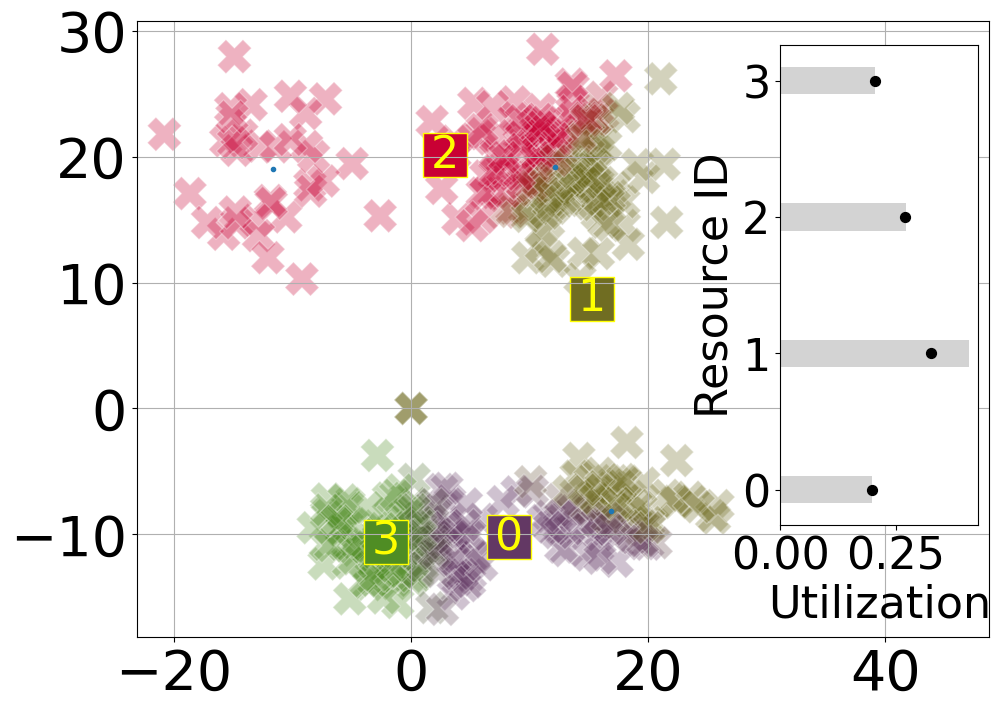

In [12]:
# reload(class_flp)

# sgf_data_file_load = 'Simulations_and_Results/final_results/Compare_CBF_SGF_AmberPenalty/SGF_N400M4_seed349.pkl'
# with open(sgf_data_file_load, 'rb') as file:
#     loaddata_sgf = pickle.load(file)

# cap_array_sgf = loaddata_sgf['cap_array']
# Y_arr_sgf = loaddata_sgf['Y_arr']
# P_arr_sgf = loaddata_sgf['P_arr']

# final_cap = cap_array_sgf[-1]
# constr_viol_c = np.min(flp.C - final_cap)
# constr_viol_b = np.min(final_cap - flp.B)
# print(f'resource locations:\n{Y_arr_sgf[-1]}')
# print(f'final capacity: {final_cap}')
# print(f'upper capacity: {flp.C}')
# print(f'lower capacity: {flp.B}')
# print(f'Relative capacity constraint violation: {constr_viol_c:.6f}\t{constr_viol_b:.6f}')
# class_flp.plot_flp_with_capacity_1(
#     flp, res_means, Y_arr_sgf, P_arr_sgf, x=np.arange(flp.M), 
#     data=cap_array_sgf[-1], min_vals=flp.B, max_vals=flp.C, 
#     x_expand_factor=0.4, y_expand_factor=0.0,
#     filedir = dir + 'SGF_N400M4_seed349.pdf', isSavePDF=True,
#     figSize=(11,8), fontSize=40, inset_loc=[0.71, 0.25, 0.18, 0.6], plotResTraj=False)

In [4]:
t0_slsqp = time.time()
F_arr_slsqp, b_arr_slsqp, P_arr_slsqp, Y_arr_slsqp, t_compute_arr_slsqp, cap_array_slsqp = flp.anneal_SLSQP(x0, beta0, betaf, beta_grow, Ftol)
t1_slsqp = time.time()

beta:2.000e-03	F:3.295e+02
beta:4.000e-03	F:3.184e+02
beta:8.000e-03	F:3.129e+02
beta:1.600e-02	F:3.101e+02
beta:3.200e-02	F:1.358e+02
beta:6.400e-02	F:1.060e+02
beta:1.280e-01	F:8.128e+01
beta:2.560e-01	F:7.202e+01
beta:5.120e-01	F:6.554e+01
beta:1.024e+00	F:6.285e+01
beta:2.048e+00	F:6.149e+01
beta:4.096e+00	F:6.067e+01
beta:8.192e+00	F:6.034e+01
beta:1.638e+01	F:6.018e+01
beta:3.277e+01	F:6.009e+01
beta:6.554e+01	F:6.005e+01
beta:1.311e+02	F:6.003e+01


In [6]:
# savedata_slsqp = {'F_arr':F_arr_slsqp,
#             'b_arr':b_arr_slsqp,
#             'P_arr':P_arr_slsqp,
#             'Y_arr':Y_arr_slsqp,
#             't_compute_arr':t_compute_arr_slsqp,
#             'cap_array':cap_array_slsqp,
#             'time_mins':t1_slsqp-t0_slsqp,
#             'C':flp.C,
#             'B':flp.B,
#             'alloc_C':flp.alloc_C,
#             'split_pct':split_pct}

# slsqp_data_file = 'Simulations_and_Results/final_results/Compare_CBF_SGF_AmberPenalty/SLSQP_N400M4_seed349.pkl'

# with open(slsqp_data_file, 'wb') as file:
#     pickle.dump(savedata_slsqp, file)


resource locations:
[[ 15.03417311  19.45529199]
 [ 11.68766646  -8.32728909]
 [  2.29074437  19.2001007 ]
 [ -2.62965855 -10.5278097 ]]
final capacity: [0.19789873 0.32740465 0.27066733 0.20402929]
upper capacity: [0.19789873 0.40740465 0.27066733 0.20402929]
lower capacity: [0. 0. 0. 0.]
Relative capacity constraint violation: -0.000000	0.197899


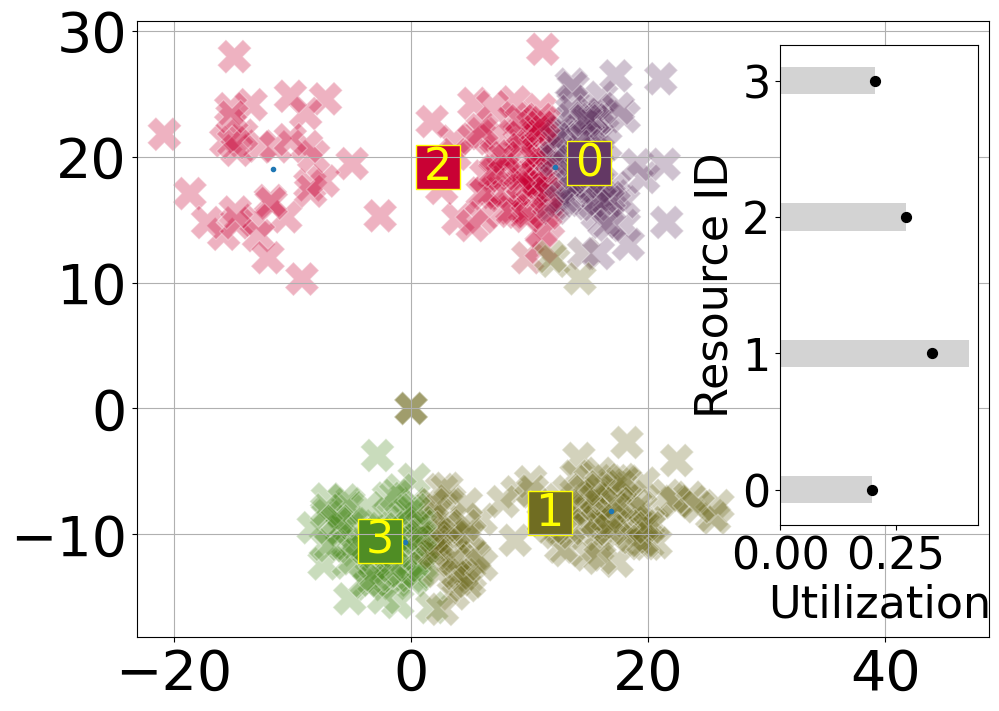

In [7]:
# reload(class_flp)

# slsqp_data_file_load = 'Simulations_and_Results/final_results/Compare_CBF_SGF_AmberPenalty/SLSQP_N400M4_seed349.pkl'
# with open(slsqp_data_file_load, 'rb') as file:
#     loaddata_slsqp = pickle.load(file)

# cap_array_slsqp = loaddata_slsqp['cap_array']
# Y_arr_slsqp = loaddata_slsqp['Y_arr']
# P_arr_slsqp = loaddata_slsqp['P_arr']

# final_cap = cap_array_slsqp[-1]
# constr_viol_c = np.min(flp.C - final_cap)
# constr_viol_b = np.min(final_cap - flp.B)
# print(f'resource locations:\n{Y_arr_slsqp[-1]}')
# print(f'final capacity: {final_cap}')
# print(f'upper capacity: {flp.C}')
# print(f'lower capacity: {flp.B}')
# print(f'Relative capacity constraint violation: {constr_viol_c:.6f}\t{constr_viol_b:.6f}')
# class_flp.plot_flp_with_capacity_1(
#     flp, res_means, Y_arr_slsqp, P_arr_slsqp, x=np.arange(flp.M), 
#     data=cap_array_slsqp[-1], min_vals=flp.B, max_vals=flp.C, 
#     x_expand_factor=0.4, y_expand_factor=0.0,
#     filedir = dir + 'SLSQP_N400M4_seed349.pdf', isSavePDF=True,
#     figSize=(11,8), fontSize=40, inset_loc=[0.71, 0.25, 0.18, 0.6], plotResTraj=False)

Our CBF total time:	45.796268 sec	1.000000 times
Our final cost:	45.726864 units
SGF CBF total time:	206.602322 sec	4.511335 times
SGF final cost:	98.766758 units
SLSQP total time:	1590.250256 sec	34.724451 times
SLSQP final cost:	60.028816 units
DAC total time:	63.200084 sec	1.380027 times
DAC final cost:	33.019808 units


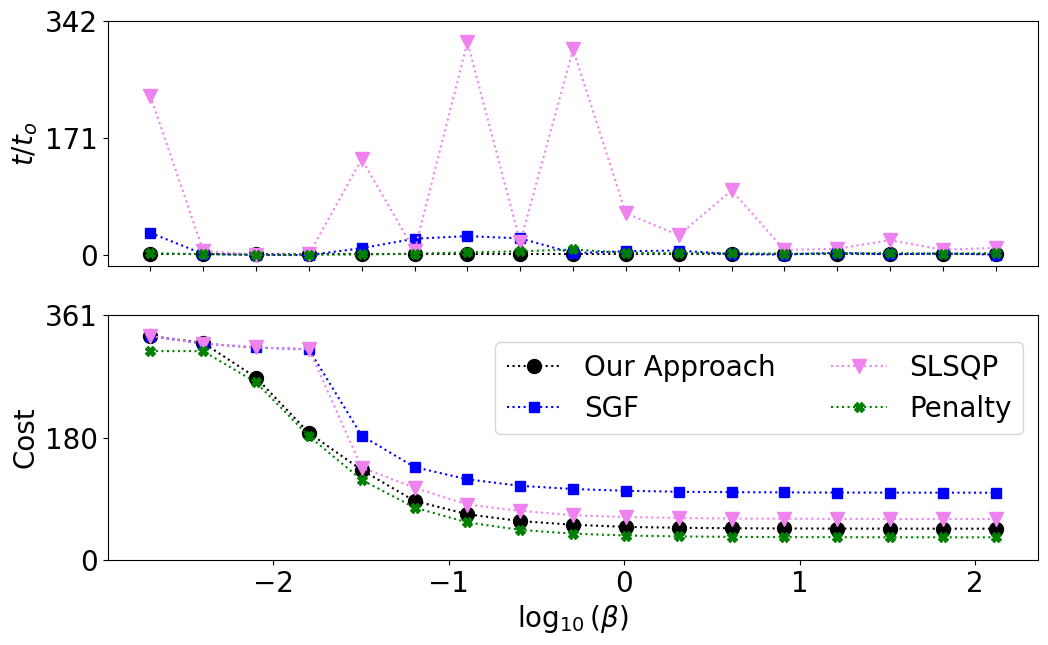

In [84]:
print(f'Our CBF total time:\t{np.sum(t_compute_arr_cbf):.6f} sec\t{1.0:.6f} times')
print(f'Our final cost:\t{F_arr_cbf[-1]:.6f} units')
print(f'SGF CBF total time:\t{np.sum(t_compute_arr_sgf):.6f} sec\t{np.sum(t_compute_arr_sgf)/np.sum(t_compute_arr_cbf):.6f} times')
print(f'SGF final cost:\t{F_arr_sgf[-1]:.6f} units')
print(f'SLSQP total time:\t{np.sum(t_compute_arr_slsqp):.6f} sec\t{np.sum(t_compute_arr_slsqp)/np.sum(t_compute_arr_cbf):.6f} times')
print(f'SLSQP final cost:\t{F_arr_slsqp[-1]:.6f} units')
print(f'DAC total time:\t{np.sum(t_compute_arr_dac):.6f} sec\t{np.sum(t_compute_arr_dac)/np.sum(t_compute_arr_cbf):.6f} times')
print(f'DAC final cost:\t{F_arr_dac[-1]:.6f} units')

# print(f'SLSQP total time:\t{np.sum(t_compute_arr_slsqp):.6f} sec\t{np.sum(t_compute_arr_slsqp)/np.sum(t_compute_arr_cbf):.6f} times')
t_rel_arr_cbf = np.array(t_compute_arr_cbf)/np.array(t_compute_arr_cbf)
t_rel_arr_sgf = np.array(t_compute_arr_sgf)/np.array(t_compute_arr_cbf)
t_rel_arr_slsqp = np.array(t_compute_arr_slsqp)/np.array(t_compute_arr_cbf)
t_rel_arr_dac = np.array(t_compute_arr_dac)/np.array(t_compute_arr_cbf)
plt.figure(figsize=(12,7))
plt.subplot(2,1,1)
plt.plot(np.log(b_arr_cbf)/np.log(10), t_rel_arr_cbf, marker='o', markersize=10, linestyle='dotted', color = 'black', label = 'Our')
plt.plot(np.log(b_arr_sgf)/np.log(10), t_rel_arr_sgf, marker='s', markersize=7, linestyle='dotted', color = 'blue', label = 'SGF')
plt.plot(np.log(b_arr_slsqp)/np.log(10), t_rel_arr_slsqp, marker='v', markersize=10, linestyle='dotted', color = 'violet', label = 'SLSQP')
plt.plot(np.log(b_arr_dac)/np.log(10), t_rel_arr_dac, marker='X', markersize=7, linestyle='dotted', color = 'green', label = 'Penalty')
# plt.xlabel(rf'$\log_{{10}}(\beta)$')
plt.ylabel(rf'${{t}}/{{t_o}}$', fontsize=20)
ymin_t, ymax_t = plt.ylim()
yticks = [int(y) for y in np.linspace(0.0, ymax_t*(1+0.05), 3)]
plt.xticks(np.log(b_arr_cbf)/np.log(10), [f" " for b in b_arr_cbf], rotation=0)  # Set x-axis labels as (N, M)
plt.yticks(yticks, fontsize=20)
# plt.title(rf'Free energy minimization time at increasing beta values for (N,M) = {flp.N, flp.M}')
# plt.grid()
# plt.legend(fontsize=17, ncol=4, loc="center", bbox_to_anchor=(0.8, -0.2))
# plt.show()
plt.subplot(2,1,2)
plt.plot(np.log(b_arr_cbf)/np.log(10), F_arr_cbf, marker='o', markersize=10, linestyle='dotted', color = 'black', label = 'Our Approach')
plt.plot(np.log(b_arr_sgf)/np.log(10), F_arr_sgf, marker='s', markersize=7, linestyle='dotted', color = 'blue', label = 'SGF')
plt.plot(np.log(b_arr_slsqp)/np.log(10), F_arr_slsqp, marker='v', markersize=10, linestyle='dotted', color = 'violet', label = 'SLSQP')
plt.plot(np.log(b_arr_dac)/np.log(10), F_arr_dac, marker='X', markersize=7, linestyle='dotted', color = 'green', label = 'Penalty')
plt.xlabel(rf'$\log_{{10}}(\beta)$', fontsize = 20)
plt.ylabel(rf'Cost', fontsize=20)
ymin_c, ymax_c = plt.ylim()
yticks = [int(y) for y in np.linspace(0.0, ymax_c*(1+0.05), 3)]
plt.yticks(yticks, fontsize=20)
plt.xticks(fontsize=20)
# plt.xticks(np.log(b_arr_cbf)/np.log(10), rotation=0)  # Set x-axis labels as (N, M)
# plt.title(rf'Optimal free energy at increasing beta values for (N,M) = {flp.N, flp.M}')
# plt.grid()
plt.legend(fontsize=20, ncol=2, loc="center", bbox_to_anchor=(0.7, 0.7))

plt.savefig(dir+'time_cost_SGF_Our.pdf', format="pdf")

plt.show()